# The Fashion MNIST - multiclass + improved
In this notebook we will work, yet again, with the Fashion MNIST dataset. We will start with simple model (the same as we used last time) which fits the training data quite well.

We start by apply batch normalisation and we will see how batch normalisation allows us to train the models faster by reducing the training error faster and more consistently (not as sensitive to hyperparameters). After that we add a dropout layer. This will have a regularising effect and reduce overfitting. Lastly, we apply L2 regularisation.

As usual we start by loading our data.

In [1]:
library(keras)
source("02-helpers.R")

use_multi_cpu()

data <- dataset_fashion_mnist()
data_train <- data$train
data_test <- data$test

## Preprocess
Now we will preprocess the data for you. You can check the lines below and see if they make sense to you.
- Scaling the pixel values
- Map the labels to one-hot encodings
- Split the training set to 80% train, 20% test.

In [2]:
x_train <- data_train$x / 255
x_test <- data_test$x / 255
y_train = to_categorical(y = data_train$y, num_classes = 10)
y_test = to_categorical(y = data_test$y, num_classes = 10)

index <- 0.8 * dim(y_train)[1]
x_val <- x_train[-(1:index),,]
y_val <- y_train[-(1:index),]

x_train <- x_train[1:index,,]
y_train <- y_train[1:index,]

## Baseline
To begin with, let us start with a simple model so that we have a baseline to compare with.

This is the same model as the basic one we created in the previous notebook. It will actually fit the data quite well but we still want to see if we can improve it and see the effects of batch normalisation, dropout and L2 regularisation. There is one slight difference between this network and the one we had before, the learning rate is slightly higher and you will see that the network will learn very slowly after a few epochs.

## Exercise 1
Create a simple model by performing the following steps
- Flatten the input
- Dense layer with 256 units
- ReLu activation
- Another dense layer with 10 units (1 for each class)
- Softmax activation

We have provided you with a skeleton which defines the compile step and fit step. You only need to fill in the layers. You should not have to change the batch size or any other hyperparameter.

The layers you need

    layer_dense()
    layer_flatten()
    layer_activation_relu()
    layer_activation_softmax()

**Hint:**
For these exercises it is better to apply the activations as a separate layer, instead of adding it to the dense layer. That is, instead of doing 

    layer_dense(units = 256, activation = "relu")
    
do 
    
    layer_dense(units = 256) %>% 
    layer_activation_relu()
This will allow us to add the batch normalisation more easily between these two layers in a later exercises.

In [ ]:
model <- keras_model_sequential() %>%
    <FILL IN>

cat(summary(model))

model %>% compile(
    optimizer = optimizer_adam(lr = 0.01),
    loss = "categorical_crossentropy",
    metrics = c("accuracy")
)

history <- model %>% fit(
    x = x_train,
    y = y_train,
    validation_data = list(x_val, y_val),
    epochs = 80,
    batch_size = 8096,
    callbacks=list(Progress$new())
)
plot(history)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
flatten_2 (Flatten)                 (None, 784)                     0           
________________________________________________________________________________
dense_3 (Dense)                     (None, 256)                     200960      
________________________________________________________________________________
re_lu_2 (ReLU)                      (None, 256)                     0           
________________________________________________________________________________
dense_4 (Dense)                     (None, 10)                      2570        
________________________________________________________________________________
softmax_2 (Softmax)                 (None, 10)                      0           
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_____________________________________

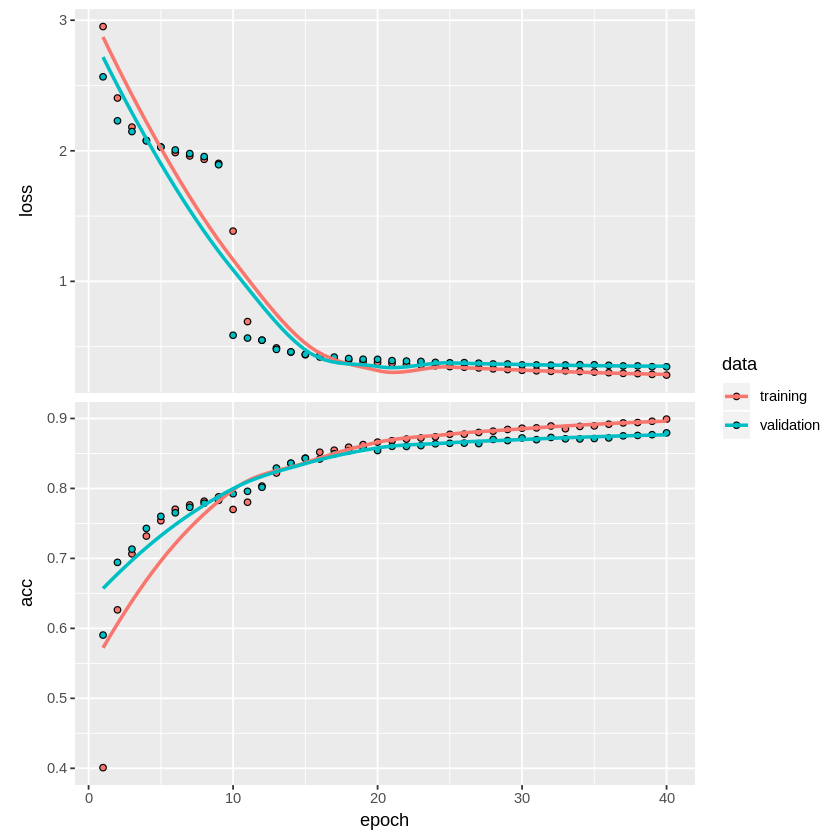

In [4]:
model <- keras_model_sequential() %>%
    layer_flatten(input_shape = c(28, 28)) %>%
    layer_dense(units = 256) %>%
    layer_activation_relu() %>%
    layer_dense(units = 10) %>%
    layer_activation_softmax()

cat(summary(model))

model %>% compile(
    optimizer = optimizer_adam(lr = 0.01),
    loss = "categorical_crossentropy",
    metrics = c("accuracy")
)

history <- model %>% fit(
    x = x_train,
    y = y_train,
    validation_data = list(x_val, y_val),
    epochs = 80,
    batch_size = 8096,
    callbacks=list(Progress$new())
)
plot(history)

In this plot you should see that our training is slow as the training quickly slows down. You should also see that the training accuracy is slightly lower than the validation accuracy. 

The training accuracy should be around 0.91-0.92 and validation accuracy around 0.87-0.88.

## Batch normalisation
The first step we take in improving our network will be to speed up learning. Batch normalisation has been shown to make networks more robust to hyperparameter selection and a larger learning rate can usually be used with batch normalisation.

The batch normalisation layer will normalise the output of the dense layer to have mean 0 and variance 1 and then scale out the activation based on the learnt beta and gamma parameters.

## Exercise 2.1
Copy the baseline network you created in excercise 1 to the cell below and add a `layer_batch_normalization` after the `layer_dense` and before the `layer_activation_relu`. Then run the model and see next question.

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
flatten_3 (Flatten)                 (None, 784)                     0           
________________________________________________________________________________
dense_5 (Dense)                     (None, 256)                     200960      
________________________________________________________________________________
batch_normalization_1 (BatchNormali (None, 256)                     1024        
________________________________________________________________________________
re_lu_3 (ReLU)                      (None, 256)                     0           
________________________________________________________________________________
dense_6 (Dense)                     (None, 10)                      2570        
________________________________________________________________________________
softmax_3 (Softmax)         

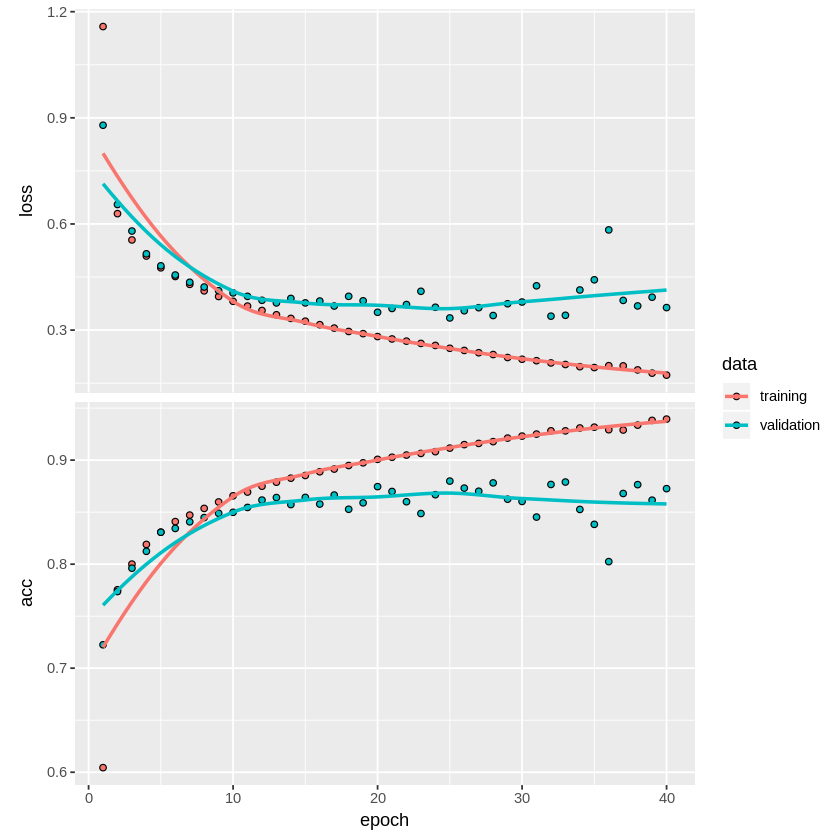

In [5]:
model <- keras_model_sequential() %>%
    layer_flatten(input_shape = c(28, 28)) %>%
    layer_dense(units = 256) %>%
    layer_batch_normalization() %>%
    layer_activation_relu() %>%
    layer_dense(units = 10) %>%
    layer_activation_softmax()

cat(summary(model))

model %>% compile(
    optimizer = optimizer_adam(lr = 0.01),
    loss = "categorical_crossentropy",
    metrics = c("accuracy")
)

history <- model %>% fit(
    x = x_train,
    y = y_train,
    validation_data = list(x_val, y_val),
    epochs = 40,
    batch_size = 8096,
    callbacks=list(Progress$new())
)
plot(history)

#### A small note on parameters for the interested
When using batch normalisation 1024 parameters are added to the model, 512 of which are "non-trainable". The 512 trainable parameters are the beta and gamma parameters for 256 units. The non-trainable parameters are the standard deviation and mean of a mini-batch computed for each 256 unit. These are considered as parameters to the model but are not trained but rather computed for each iteration.

## Exercise 2.2
If you compare this graph to the baseline. In particular, what do you notice with the training accuracy? Do you think it is reasonable to assume that the learning rate might have been too large for the baseline model (you can also experiment with it)? Do you think that the Batch normalisation layer is helpful in this case? What about the validation accuracy? Why do you think it goes down? Do you think we should reduce the number of epochs?

Answer these questions with full sentences.

You should see that the training accuracy is considerably higher for the model which uses batch normalisation, we overfit slightly to the data when using batch normalisation, causing decreased validation accuracy.

This means that the batch normalised model learns better/faster with a higher learning rate. Thus, it is able to overfit the data even more quickly.

Is the batch normalisation layer helpful? Hard to say, it seems that we would need to stop training a lot earlier, at around 30 epochs to get the same performance. 

## Dropout
Let us improve our batch normalisation network by adding some dropout. Dropout has a regularising effect on the model, that is, it will reduce overfitting. We should notice reduced training accuracy and usually a higher validation accuracy.

## Exercise 3.1
Copy the baseline network you created in exercise 2.1 to the cell below and add a `layer_dropout(rate = ?)` after `layer_activation_relu`. If you reduced the number of epochs in the model in exercise 2.1, keep that number of epochs.

Dropout takes a single parameter, the "drop-rate". This is the fraction of neurons in the layer it will set to 0. If we set the rate to 1, we will set all the activations to 0. If we set the rate to 0 we will let the activations remain the same. The best performing values are usually between 0.2 and 0.5.

Try out a few values, but do not try to close the gap between the training accuracy and validation accuracy completely (you can't).

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
flatten_4 (Flatten)                 (None, 784)                     0           
________________________________________________________________________________
dense_7 (Dense)                     (None, 256)                     200960      
________________________________________________________________________________
batch_normalization_2 (BatchNormali (None, 256)                     1024        
________________________________________________________________________________
re_lu_4 (ReLU)                      (None, 256)                     0           
________________________________________________________________________________
dropout_1 (Dropout)                 (None, 256)                     0           
________________________________________________________________________________
dense_8 (Dense)             

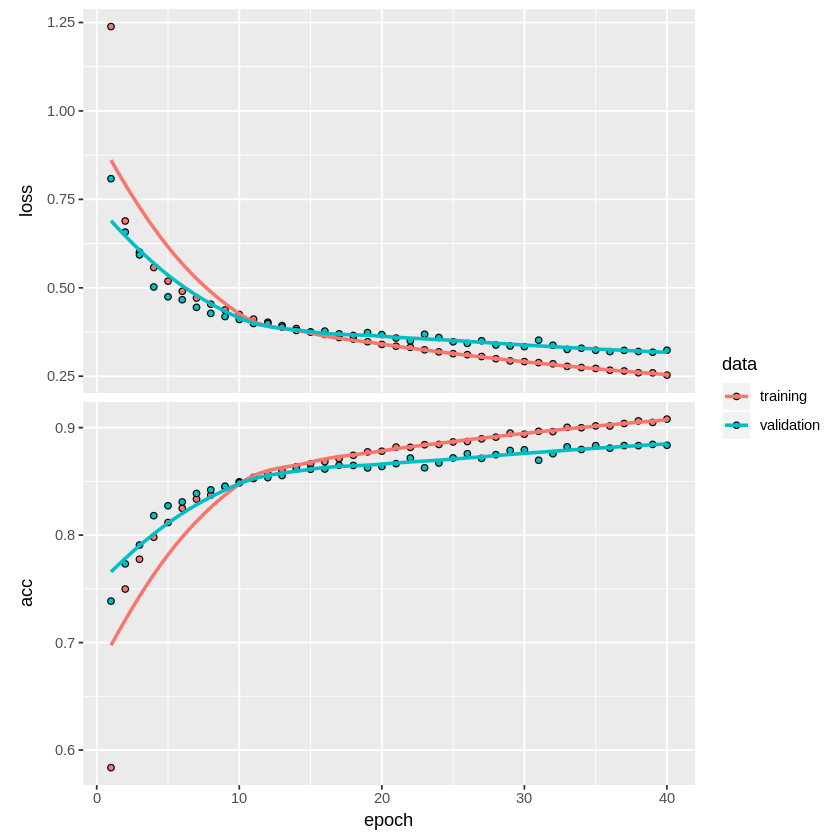

In [6]:
model <- keras_model_sequential() %>%
    layer_flatten(input_shape = c(28, 28)) %>%
    layer_dense(units = 256) %>%
    layer_batch_normalization() %>%
    layer_activation_relu() %>%
    layer_dropout(rate = 0.4) %>%
    layer_dense(units = 10) %>%
    layer_activation_softmax()

cat(summary(model))

model %>% compile(
    optimizer = optimizer_adam(lr = 0.01),
    loss = "categorical_crossentropy",
    metrics = c("accuracy")
)

history <- model %>% fit(
    x = x_train,
    y = y_train,
    validation_data = list(x_val, y_val),
    epochs = 40,
    batch_size = 8096,
    callbacks=list(Progress$new())
)
plot(history)

## Exercise 3.2
If you compare this graph to the batch normalisation network graph, what do you notice? Do you think we are reducing overfitt? Has our validation accuracy increased? Should we prefer this model over the baseline? Do you think that we could do away with fewer epochs? Try answering these quests with full sentences in the cell below.

Here we see that dropout decreases the training accuracy again as the model has a more difficult time during training but at the same time we do not see increased validation accuracy.

The numbers look very similar to our baseline, but at the same time, this model is more robust against hyperparameter selction and will (usually) perform better on the test data. So we would prefer this model to the baseline.

## L2 Regularisation
Let us now close the gap between our training and validation set by using L2 regularisation. 

L2 regularisation associates costs to the weights our network learns. We need to select a hyperparameter, lambda, which is a discount factor of the L2 term. If we set lambda too high, the network will not be able to update the weights large enough. If we set lambda too low, it will have no regularising effects and we will continue to overfit.

Notice that when we train using L2 regularisation, the L2 term will not affect the loss function much at first, since most weights have value around 0 (weights are initialised with mean 0 and variance 1, bias 0). When the network trains more and more, the weights for certain features will grow (positively or negatively) and the L2 term will grow as well and become a greater factor of the overall loss. Our goal is to make the L2 term start growing when we would have otherwise started overfitting.

Let us try it out!

## Exercise 4.1
Copy the baseline network you created in exercise 2.1, not the one from 3.1 (Dropout) and add `kernel_regularizer = regularizer_l2(l = lambda)` as an additional parameter to `layer_dense`. You will need to set the value of `lambda`.

    layer_dense(units = 128, kernel_regularizer = regularizer_l2(l = lambda))
    
Try a few different values for lambda, 0.0001 up to 0.0000001, using 80 epochs.

In [ ]:
l2_regulariser = regularizer_l2(l = 0.000001)

model <- keras_model_sequential() %>%
    layer_flatten(input_shape = c(28, 28)) %>%
    layer_dense(units = 256, kernel_regularizer = l2_regulariser) %>%
    layer_batch_normalization() %>%
    layer_activation_relu() %>%
    layer_dense(units = 10, kernel_regularizer = l2_regulariser) %>%
    layer_activation_softmax()

cat(summary(model))

model %>% compile(
    optimizer = optimizer_adam(lr = 0.01),
    loss = "categorical_crossentropy",
    metrics = c("accuracy")
)

history <- model %>% fit(
    x = x_train,
    y = y_train,
    validation_data = list(x_val, y_val),
    epochs = 80,
    batch_size = 8096,
    callbacks=list(Progress$new())
)
plot(history)

Things are getting hairy! You should notice that the loss and accuracy have high variance now.

## Exercise 4.2
What do you notice when using lambda = 0.0001? And what about 0.0000001? Try answering these quiestion in full sentences below.

For 0.0001 we should see that we are constraining the network too much and with 0.000001 we do not constrain the model at all.

## Exercise 4.3
Which model do you think is better, the one which uses dropout or L2 regularisation? Do you think that L2 regularisation is helping us in this case? Do you think that we would be better off using fewer epochs? Select the model which you think is best and evaluate it using the cell below. What is your score?

In [ ]:
model %>% evaluate(x_test, y_test)

## Bonus exercise
Like in the previous notebook, try improving this model by making the network thinner but deeper. Try using batch normalisation and dropout at multiple (correct/meaningful) locations in the network. Lastly, try using different optimisers, a more basic one, such as [mini-batch gradient descent](https://keras.rstudio.com/reference/optimizer_sgd.html) or [RMSprop](https://keras.rstudio.com/reference/optimizer_rmsprop.html) in your network. Do you notice any differences?

In [ ]:
model <- keras_model_sequential() %>%
    <FILL IN>

cat(summary(model))

model %>% compile(
    optimizer = optimizer_adam(lr = 0.01),
    # optimizer = optimizer_rmsprop (lr = 0.01),
    # optimizer = optimizer_sgd(lr = 0.01),
    loss = "categorical_crossentropy",
    metrics = c("accuracy")
)

history <- model %>% fit(
    x = x_train,
    y = y_train,
    validation_data = list(x_val, y_val),
    epochs = 80,
    batch_size = 8096,
    callbacks=list(Progress$new())
)
plot(history)

In [ ]:
model <- keras_model_sequential() %>%
    layer_flatten(input_shape = c(28, 28)) %>%
    layer_dense(units = 128) %>%
    layer_batch_normalization() %>%
    layer_activation_relu() %>%
    layer_dropout(rate = 0.4) %>%
    layer_dense(units = 128, activation = "relu") %>%
    layer_batch_normalization() %>%
    layer_activation_relu() %>%
    layer_dropout(rate = 0.4) %>%
    layer_dense(units = 64, activation = "relu") %>%
    layer_batch_normalization() %>%
    layer_activation_relu() %>%
    layer_dropout(rate = 0.4) %>%
    layer_dense(units = 32, activation = "relu") %>%
    layer_dense(units = 10, activation = "softmax")

cat(summary(model))

model %>% compile(
    optimizer = optimizer_adam(lr = 0.01),
    loss = "categorical_crossentropy",
    metrics = c("accuracy")
)

history <- model %>% fit(
    x = x_train,
    y = y_train,
    validation_data = list(x_val, y_val),
    epochs = 40,
    batch_size = 8096,
    callbacks=list(Progress$new())
)
plot(history)